In [1]:
import arviz as az
import io
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import pymc as pm
import pytensor.tensor as pt
import requests
import statsmodels.api as sm
import warnings
import xarray as xr

#seed = sum(map(ord, "PyMC LABS - BVAR"))
#rng = np.random.default_rng(seed=seed)

warnings.filterwarnings(
    "ignore",
    category=UserWarning,
    module="openpyxl.worksheet._reader",
)

In [2]:
def companion_eigs(A_draw):
    """
    A_draw: (p, K, K) with VAR form y_t = sum_{l=1}^p A_l y_{t-l} + ...
    Returns eigenvalues of the companion matrix.
    """
    p, K, _ = A_draw.shape
    C = np.zeros((K*p, K*p))
    C[:K, :K*p] = np.hstack([A_draw[l] for l in range(p)])
    if p > 1:
        C[K:, :-K] = np.eye(K*(p-1))
    return np.linalg.eigvals(C)

def irf_from_A(A_draw, shock_idx, horizons=40, shock_size=1.0):
    """
    A_draw: (p, K, K)
    shock_idx: index of shocked variable in vars_endog ordering
    horizons: number of steps ahead
    shock_size: size of shock applied to y_t at impact (in the same units as the standardized data)
    Returns: (horizons+1, K) IRF path.
    """
    p, K, _ = A_draw.shape

    # Companion matrix
    C = np.zeros((K*p, K*p))
    C[:K, :K*p] = np.hstack([A_draw[l] for l in range(p)])
    if p > 1:
        C[K:, :-K] = np.eye(K*(p-1))

    # Impact shock to current period
    state = np.zeros(K*p)
    state[shock_idx] = shock_size

    out = np.zeros((horizons+1, K))
    out[0] = state[:K]

    for h in range(1, horizons+1):
        state = C @ state
        out[h] = state[:K]

    return out

def companion_eigs(A_draw):
    """
    A_draw: (lags, K, K) with VAR form y_t = sum_{l=1}^p A_l y_{t-l} + ...
    returns eigenvalues of companion matrix
    """
    p, K, _ = A_draw.shape
    C = np.zeros((K*p, K*p))
    C[:K, :K*p] = np.hstack([A_draw[l] for l in range(p)])
    if p > 1:
        C[K:, :-K] = np.eye(K*(p-1))
    return np.linalg.eigvals(C)

Most data found here:
- https://econweb.ucsd.edu/~vramey/research.html
- Government Spending Multipliers in Good Times and in Bad: Evidence from U.S. Historical Data
- Data and Programs

TFP found here:
- https://www.longtermproductivity.com/download.html

In [3]:
data_path = Path(Path.cwd().parent / "data processed" / "ads_dataset_w_def.csv")
print("Processed ADS dataset")
print("Full file path: ",data_path)
print("File exists: ",data_path.exists())

Processed ADS dataset
Full file path:  /Users/awalters/escp_phd/govt_spending/data processed/ads_dataset_w_def.csv
File exists:  True


In [4]:
df = pd.read_csv(data_path)
df = df.copy()
df = df.set_index("date")

In [5]:
df

,def_delta,rgdppc,govpc,tbill,totdefgdp,feddebtgdp,tfp_adj
date,,,,,,,
1890-01-01,0.008303,-5.377503,-8.489825,4.247273,0.841634,8.122039,1.000000
1890-04-01,0.003715,-5.367321,-8.361955,4.038435,0.744001,7.814325,1.000731
1890-07-01,-0.002246,-5.357144,-8.254742,4.397253,0.411837,7.330389,1.019988
1890-10-01,-0.004014,-5.339102,-8.254618,5.452498,0.412199,6.976309,1.038773
1891-01-01,-0.005413,-5.345935,-8.304856,4.306070,0.359541,6.808374,1.035873
...,...,...,...,...,...,...,...
2013-10-01,-0.073181,-3.003386,-4.697843,0.060000,-3.480437,73.254532,2.980584
2014-01-01,-0.071685,-3.007488,-4.701208,0.050000,-3.928921,74.179534,2.980497
2014-04-01,-0.054896,-2.998031,-4.700774,0.030000,-3.958314,74.000651,2.978646


In [6]:
vars_endog = [
    "def_delta", #defense spending as % of gdp, change over next year
    "govpc",
    "rgdppc",
    "tbill",
    "tfp_adj",
    "totdefgdp",
    "feddebtgdp",
    ]

data = df[vars_endog].dropna().copy()

# strongly recommended for 60 lags
data_z = (data - data.mean()) / data.std()

Y = data_z.values
T, K = Y.shape

lags = 60

# Target: y_t for t = lags..T-1
Y_target = Y[lags:]                      # shape (T-lags, K)

# Lagged predictors: stack y_{t-1},...,y_{t-lags}
# shape (T-lags, lags, K)
Xlags = np.stack([Y[lags-(i+1):-(i+1)] for i in range(lags)], axis=1)

print("Y_target:", Y_target.shape, "Xlags:", Xlags.shape, "K:", K, "T:", T)

Y_target: (440, 7) Xlags: (440, 60, 7) K: 7 T: 500


In [7]:
lags = 60
K = len(vars_endog)

coords = {
    "time": np.arange(Y_target.shape[0]),
    "vars": vars_endog,
    "cross_vars": vars_endog,
    "lags": np.arange(1, lags+1),
}

# --- Minnesota hyperparameters ---
lambda_ = 0.12   # overall tightness
alpha   = 1.5    # lag decay
theta   = 0.25   # cross-variable shrinkage (<1)

lag_idx = np.arange(1, lags+1)
lag_scale = lambda_ / (lag_idx ** alpha)            # (lags,)

own_mask = np.eye(K)
cross_mask = 1 - own_mask
var_scale = own_mask + theta * cross_mask           # (K,K)

# prior std for each coefficient: sigma[l, eq, var]
sigma_A = lag_scale[:, None, None] * var_scale[None, :, :]  # (lags,K,K)

# Optional: random-walk mean (own lag-1 centered at 1, others at 0)
mu_A = np.zeros((lags, K, K))
rw_vars = {"rgdppc", "govpc", "tfp_adj"}          # these are in logs in your VAR
# everything else (tbill, totdefgdp, feddebtgdp, pdvmily) gets mean 0 on own lag 1

for j, name in enumerate(vars_endog):
    if name in rw_vars:
        mu_A[0, j, j] = 1.0

with pm.Model(coords=coords) as BVAR_model:
    X = pm.Data("Xlags", Xlags, dims=("time","lags","cross_vars"))
    Yobs = pm.Data("Y_target", Y_target, dims=("time","vars"))

    intercept = pm.Normal("intercept", 0.0, 1.0, dims=("vars",))
    noise = pm.HalfNormal("noise", 1.0, dims=("vars",))

    lag_coefs = pm.Normal(
        "lag_coefs",
        mu=pt.constant(mu_A.astype("float32")),
        sigma=pt.constant(sigma_A.astype("float32")),
        dims=("lags","vars","cross_vars")
    )

    mean = intercept + pt.einsum("tlk,ljk->tj", X, lag_coefs)

    obs = pm.Normal("obs", mu=mean, sigma=noise, observed=Yobs, dims=("time","vars"))

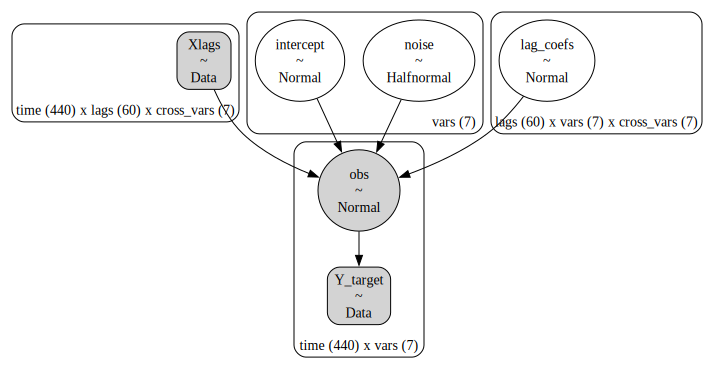

In [8]:
pm.model_to_graphviz(BVAR_model)

In [9]:
with BVAR_model:
    trace = pm.sample(
        draws=1000,
        tune=1000,
        chains=10,
        cores=10,
        target_accept=0.95,
    )

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (10 chains in 10 jobs)
NUTS: [intercept, noise, lag_coefs]


Output()

Sampling 10 chains for 1_000 tune and 1_000 draw iterations (10_000 + 10_000 draws total) took 500 seconds.


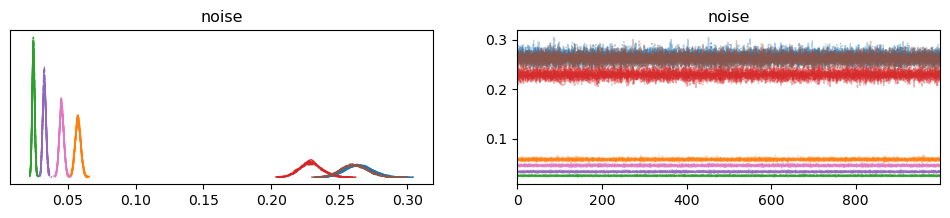

In [10]:
az.plot_trace(trace, var_names=["noise"]);

In [11]:
post = trace.posterior.stack(sample=("chain","draw"))
A = post["lag_coefs"].values   # (lags, vars, cross_vars, sample)
A = np.moveaxis(A, -1, 0)      # (sample, lags, K, K)

rng = np.random.default_rng(123)
idx = rng.choice(A.shape[0], size=min(200, A.shape[0]), replace=False)

max_mods = []
for i in idx:
    eigs = companion_eigs(A[i])
    max_mods.append(np.max(np.abs(eigs)))

np.mean(np.array(max_mods) < 1), np.quantile(max_mods, [0.5, 0.9, 0.99])

(np.float64(0.745), array([0.99805261, 1.00176945, 1.00687615]))

In [12]:
post = trace.posterior.stack(sample=("chain","draw"))
A = post["lag_coefs"].values
A = np.moveaxis(A, -1, 0)  # (sample, p, K, K)

max_mod = np.empty(A.shape[0])
for i in range(A.shape[0]):
    eigs = companion_eigs(A[i])
    max_mod[i] = np.max(np.abs(eigs))

stable_idx = np.where(max_mod < 1.0)[0]
stable_idx.size / A.shape[0]

0.7515

In [13]:
shock_var = "def_delta"
#shock_var = "log_tfp"
shock_idx = vars_endog.index(shock_var)

shock_unstd = 1.0   # +1 pp of GDP (since news_gdp is in percent units)

# 1% shock in log units (exact)
#shock_unstd = np.log(1.01)

shock_std = shock_unstd / data[shock_var].std()
shock_std

np.float64(1.1668637205691306)

In [14]:
H = 60
rng = np.random.default_rng(123)

use = rng.choice(stable_idx, size=min(10000, stable_idx.size), replace=False)

irfs = np.stack(
    [irf_from_A(A[i], shock_idx, horizons=H, shock_size=shock_std) for i in use],
    axis=0
)
# irfs shape: (draws, H+1, K) in standardized units

In [15]:
# Convert standardized IRFs back to original units
std_vec = data[vars_endog].std().to_numpy()
irfs_unstd = irfs * std_vec[None, None, :]  # (draws, horizon, K)

# --- Normalize so that G/Y rises by +1pp of GDP over the first year ---
gov_name = "govpc"   # <-- log(Gov per cap) in your VAR
gdp_name = "rgdppc"  # <-- log(GDP per cap) in your VAR

gov_idx = vars_endog.index(gov_name)
gdp_idx = vars_endog.index(gdp_name)

# baseline government share of GDP (percent)
s0 = 100.0 * np.median(np.exp(data[gov_name] - data[gdp_name]))

# implied IRF of G/Y in percentage points of GDP
dlog_share = irfs_unstd[:, :, gov_idx] - irfs_unstd[:, :, gdp_idx]
g_y_irf_pp = s0 * (np.exp(dlog_share) - 1.0)

first_year = slice(0, 4)   # quarterly; use slice(0, 1) if annual
cum_first_year = g_y_irf_pp[:, first_year].sum(axis=1)

scale = 1.0 / np.median(cum_first_year) / 4   # target = +1pp of GDP
irfs_unstd *= scale
# ---------------------------------------------------------------

# Plotting conversion (only logs -> percent)
log_vars = {"rgdppc", "govpc", "tfp_adj"}   # if these are logs in the VAR
irfs_plot = irfs_unstd.copy()
for j, name in enumerate(vars_endog):
    if name in log_vars:
        irfs_plot[:, :, j] = 100 * irfs_unstd[:, :, j]

# Use a unit shock in standardized space (since you normalize via `scale`)
shock_std = 1.0

In [16]:
print(data.describe().T[["mean","std","min","max"]])

                 mean        std        min         max
def_delta    0.006822   0.856998  -5.718057    5.758207
govpc       -6.104889   1.223717  -8.489825   -4.586838
rgdppc      -4.203339   0.779441  -5.478265   -2.986680
tbill        3.579365   2.645134   0.013333   15.053000
tfp_adj      2.023699   0.675352   0.918845    2.988200
totdefgdp   -2.927562   4.886502 -28.326565    4.610020
feddebtgdp  33.464308  22.085768   2.745711  115.184399


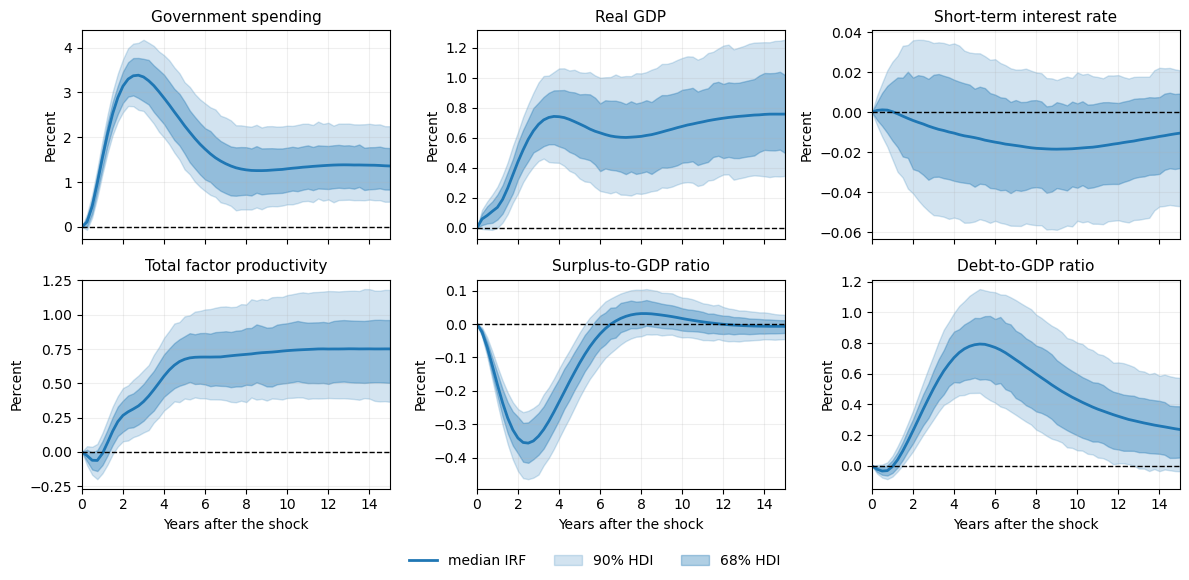

In [19]:
horiz_years = np.arange(H + 1) / 4

# --- layout ---
nrows, ncols = 2, 3
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 6), sharex=True)
axes = axes.ravel()

xmax = 15
xticks = np.arange(0, xmax + 1, 2)

pretty = {
    "govpc": "Government spending",
    "rgdppc": "Real GDP",
    "tbill": "Short-term interest rate",
    "tfp_adj": "Total factor productivity",
    "totdefgdp": "Surplus-to-GDP ratio",
    "feddebtgdp": "Debt-to-GDP ratio",
}

names = vars_endog[1:]  # skip shock var
for ax, name in zip(axes, names):
    j = vars_endog.index(name)  # robust index into irfs_plot

    y = irfs_plot[:, :, j]                 # (draw, horizon)
    med = np.median(y, axis=0)

    arr = xr.DataArray(y, dims=("draw", "horizon")).expand_dims(chain=[0])
    hdi68 = az.hdi(arr, hdi_prob=0.68).to_array().squeeze()
    hdi90 = az.hdi(arr, hdi_prob=0.90).to_array().squeeze()

    lo68 = hdi68.sel(hdi="lower").values
    hi68 = hdi68.sel(hdi="higher").values
    lo90 = hdi90.sel(hdi="lower").values
    hi90 = hdi90.sel(hdi="higher").values

    ax.plot(horiz_years, med, linewidth=2, color="C0", label="median IRF")
    ax.fill_between(horiz_years, lo90, hi90, alpha=0.20, color="C0", label="90% HDI")
    ax.fill_between(horiz_years, lo68, hi68, alpha=0.35, color="C0", label="68% HDI")

    ax.axhline(0, lw=1, ls="--", color="black")  # dashed zero line
    ax.set_xlim(0, xmax)
    ax.set_xticks(xticks)

    ax.set_title(pretty.get(name, name), fontsize=11)
    ax.set_ylabel("Percent")
    ax.grid(alpha=0.2)

# turn off any unused axes (if < 6 plots)
for k in range(len(names), len(axes)):
    axes[k].axis("off")

# x-label only on bottom row
for ax in axes[-ncols:]:
    ax.set_xlabel("Years after the shock")

# one shared legend (avoid repeating)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=3, frameon=False)

#fig.suptitle("Impulse Responses to Defense Expenditure Shock", y=0.995, fontsize=14)
fig.tight_layout(rect=[0, 0.05, 1, 0.97])
plt.savefig(Path.cwd().parent / "figures" / "ADS_w_mil_change.png")